In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Imports for plotting and visualizations

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

# for regular expressions
import re

# Data Loading

Load training data

In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
train_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


Load test data

In [4]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


Check the rate of women that survived out of all survivors. 

In [5]:
women = train_df.loc[train_df.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


Rate of men who survived.

In [6]:
men = train_df.loc[train_df.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


Preliminary data analysis, to see what pre-processing might be required. 

In [7]:
# check the balance of the data
survived = train_df.loc[train_df.Survived == 1]
rate_survived = len(survived)/len(train_df)

#print("% of people who survived:", rate_survived)

#check that we have only 1 and 0 in the survived column:
#print(train_df["Survived"].unique())

#check other features:
#print("Pclass", train_df["Pclass"].unique())
# TODO: 1 hot code encoding
#print("Sex", train_df["Sex"].unique())
# TODO: we have nan age values "nan" to be replaced with zero
# TODO: we have estimated values we might want to drop and let XGBoost estimate?
#print("Age", train_df["Age"].unique())

#print("SibSp", train_df["SibSp"].unique())
#print("Parch", train_df["Parch"].unique())
# TODO: need to convert ticket to numeric
#print("Ticket", train_df["Ticket"].unique()) 
#print("Fare", train_df["Fare"].unique())
# verify Fare is numeric:
#print("Fare dtype:", train_df["Fare"].dtype)
# TODO: we have nan values to be modified to 0, and then 1 hot encode
#print("Cabin", train_df["Cabin"].unique())
# TODO: we have nan values to be modified to 0 and use 1 hot encoding
#print("Embarked", train_df["Embarked"].unique())

#train_df.dtypes

# Data Pre-processing
Methodology was as follows:
1) Understand feature correlation to surviving rate/other features

2) Group importand features to distinct groups that will assist the model with generalization

3) Run XGboost, plot the important features graph and repeat the process

Age feature pre-processing

In [8]:
# replace the nan age with a 0
train_df.loc[pd.isna(train_df['Age']), 'Age'] = 0
test_df.loc[pd.isna(test_df['Age']), 'Age'] = 0

# add a bool feature for predicted age:
train_df['Predicted_age'] = train_df['Age'].apply(lambda x : (x*10%10 == 5) or x ==0 )
test_df['Predicted_age'] = test_df['Age'].apply(lambda x : (x*10%10 == 5) or x ==0 )

In [9]:

# Define regex pattern for extracting letters from strings
class_regex_pattern = r'^([A-Za-z]+)?'


# replace the nan Fare with a 0
train_df.loc[pd.isna(train_df['Fare']), 'Fare'] = 0
test_df.loc[pd.isna(test_df['Fare']), 'Fare'] = 0


# Extract ticket length then drop the ticket
# Commenting this out, as it was found useless
#train_df['Ticket_len'] = train_df['Ticket'].apply(lambda x : len(x))
#test_df['Ticket_len'] = test_df['Ticket'].apply(lambda x : len(x))

train_df['Ticket_num'] = train_df['Ticket'].apply( \
    lambda x: x.split(' ')[1] if len(x.split(' ')) > 1 else 0)
test_df['Ticket_num'] = test_df['Ticket'].apply( \
    lambda x: x.split(' ')[1] if len(x.split(' ')) > 1 else 0)

train_df.loc[train_df['Ticket_num'] == '2.', 'Ticket_num'] = '2'
train_df.loc[train_df['Ticket_num'] == 'Basle', 'Ticket_num'] = '541'

#print("train", train_df['Ticket_num'].unique())
#print("test" ,test_df['Ticket_num'].unique())
# Let's transform the numbers to numeric values:
train_df['Ticket_num'] = pd.to_numeric(train_df['Ticket_num'])
test_df['Ticket_num'] = pd.to_numeric(test_df['Ticket_num'])

train_df = train_df.assign(Ticket_class=train_df['Ticket'].str.extract(class_regex_pattern)[0])
test_df = test_df.assign(Ticket_class=test_df['Ticket'].str.extract(class_regex_pattern)[0])

train_df.drop(['Ticket'], axis=1, inplace=True)
test_df.drop(['Ticket'], axis=1, inplace=True)

# replace the nans with 0
train_df.loc[pd.isna(train_df['Ticket_class']), 'Ticket_class'] = 0
test_df.loc[pd.isna(test_df['Ticket_class']), 'Ticket_class'] = 0

# replace the nans with 0
train_df.loc[pd.isna(train_df['Cabin']), 'Cabin'] = 0
test_df.loc[pd.isna(test_df['Cabin']), 'Cabin'] = 0

# Use str.extract to extract the class letters
train_df = train_df.assign(Cabin_class=train_df['Cabin'].str.extract(class_regex_pattern)[0])
test_df = test_df.assign(Cabin_class=test_df['Cabin'].str.extract(class_regex_pattern)[0])

# set the 'T' cabin class to 'A', so that we have a match between test and
# train cabin class, for 1-hot encoding
train_df.loc[train_df['Cabin_class'] == 'T', 'Cabin_class'] = 'A'

train_df.loc[pd.isna(train_df['Cabin']), 'Cabin'] = 0
test_df.loc[pd.isna(test_df['Cabin']), 'Cabin'] = 0

# Now extract the number:
cabin_regex_num_pattern = r'([0-9]+)'

#train_df = train_df.assign(Cabin_num=train_df['Cabin'].str.extract(cabin_regex_num_pattern)[0])
#test_df = test_df.assign(Cabin_num=test_df['Cabin'].str.extract(cabin_regex_num_pattern)[0])

#train_df.loc[pd.isna(train_df['Cabin_num']), 'Cabin_num'] = 0
#test_df.loc[pd.isna(test_df['Cabin_num']), 'Cabin_num'] = 0
#train_df.loc[train_df['Cabin_num']]
#print("cabin number values: ", train_df['Cabin_num'].unique())
#print("cabin class values: ", train_df['Cabin_class'].unique())
#print("cabin original values: ", train_df['Cabin'].unique())

# Now I no longer need the original cabin value
train_df.drop(['Cabin'], axis=1, inplace=True)
test_df.drop(['Cabin'], axis=1, inplace=True)

# Let's transform the numbers to numeric values:
#train_df['Cabin_num'] = pd.to_numeric(train_df['Cabin_num'])
#test_df['Cabin_num'] = pd.to_numeric(test_df['Cabin_num'])
#print("cabin number values: ", train_df['Cabin_num'].unique())


# Now let's have a look on all columns:
#print(train_df.head())

In [10]:
from sklearn.preprocessing import LabelEncoder

#################################################
# Set missing cabin to Cabin median per Pclass #
################################################

#combined_df = pd.concat([train_df, test_df], axis=0)

# Group by 'Pclass' and find the most common 'Cabin' value in each group
cabin_by_pclass = train_df.groupby('Pclass')['Cabin_class'].agg(lambda x: x.mode().iloc[0] if (not x.mode().empty) and (x.mode().iloc[0] != 0) else None).reset_index()
print(cabin_by_pclass)

# Merge the most common cabin values back to the original DataFrame
train_df = pd.merge(train_df, cabin_by_pclass, how='left', on='Pclass', suffixes=('', '_most_common'))
test_df = pd.merge(test_df, cabin_by_pclass, how='left', on='Pclass', suffixes=('', '_most_common'))

# Fill missing values in 'Cabin' with the most common value for each 'Pclass'
train_df['Cabin_class'] = train_df['Cabin_class'].fillna(train_df['Cabin_class_most_common'])
test_df['Cabin_class'] = test_df['Cabin_class'].fillna(test_df['Cabin_class_most_common'])

# Drop the auxiliary column used for merging if needed
train_df = train_df.drop(columns=['Cabin_class_most_common'])
test_df = test_df.drop(columns=['Cabin_class_most_common'])

# Now, df contains the 'Cabin' column with missing values filled based on the majority of cabins in their 'Pclass' group

   Pclass Cabin_class
0       1           C
1       2           F
2       3           F


In [11]:
# Group by 'Pclass' and find the most common 'Cabin' value in each group
survived_by_cabin_class = train_df.groupby('Cabin_class')['Survived'].mean().reset_index()
print(survived_by_cabin_class)

#sns.countplot(x='Cabin_class', hue='Pclass', data=train_df)

#plt.title('Cabin_class count train')
#plt.xlabel('Cabin_class')
#plt.ylabel('Count')
#plt.show()


#sns.countplot(x='Cabin_class', data=test_df)

#plt.title('Cabin_class count test')
#plt.xlabel('Cabin_class')
#plt.ylabel('Count')
#plt.show()

  Cabin_class  Survived
0           A  0.437500
1           B  0.744681
2           C  0.545455
3           D  0.757576
4           E  0.750000
5           F  0.295455
6           G  0.500000


Create groups of cabin classes, per survived rate

We got previously that:

  Cabin_class  Survived

A  0.437500

B  0.744681

C  0.545455

D  0.757576

E  0.750000

F  0.295455

G  0.500000

Hence the groups will be: 
High survivor rate: (B, D, E)
Medium survivor rate: (A, C, G)
Low survior rate: F


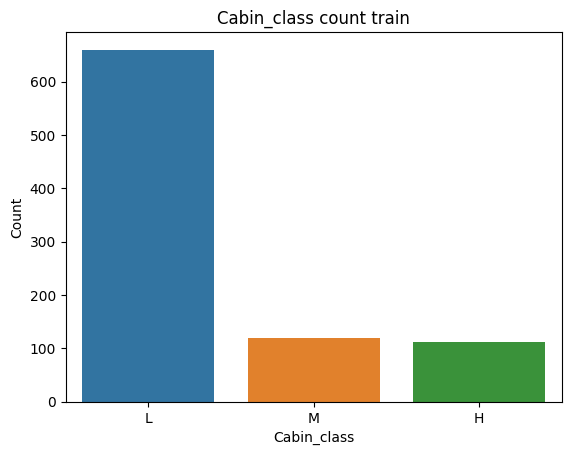

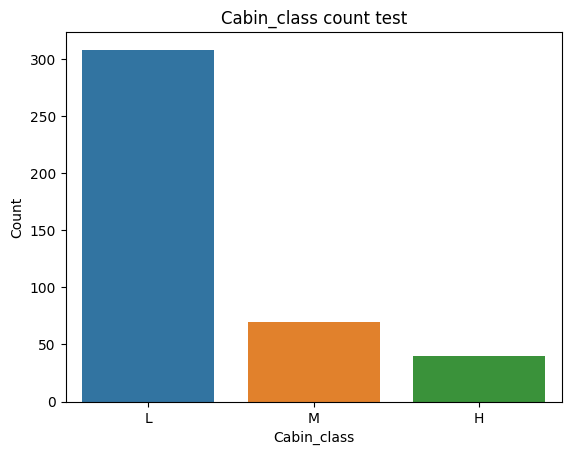

In [12]:
cabin_class_high = ['B', 'D', 'E']
cabin_class_medium = ['A', 'C', 'G']
cabin_class_low = ['F']

train_df.loc[(train_df['Cabin_class'].isin(cabin_class_high)), 'Cabin_class'] = 'H'
train_df.loc[(train_df['Cabin_class'].isin(cabin_class_medium)), 'Cabin_class'] = 'M'
train_df.loc[(train_df['Cabin_class'].isin(cabin_class_low)), 'Cabin_class'] = 'L'


test_df.loc[(test_df['Cabin_class'].isin(cabin_class_high)), 'Cabin_class'] = 'H'
test_df.loc[(test_df['Cabin_class'].isin(cabin_class_medium)), 'Cabin_class'] = 'M'
test_df.loc[(test_df['Cabin_class'].isin(cabin_class_low)), 'Cabin_class'] = 'L'


sns.countplot(x='Cabin_class', data=train_df)

# You can customize the plot as needed
plt.title('Cabin_class count train')
plt.xlabel('Cabin_class')
plt.ylabel('Count')
plt.show()


sns.countplot(x='Cabin_class', data=test_df)

# You can customize the plot as needed
plt.title('Cabin_class count test')
plt.xlabel('Cabin_class')
plt.ylabel('Count')
plt.show()


The fare is an important feature - let's create fare groups for higher correlation in test

In [13]:
######################################
# Set missing fare to Pclass median #
#####################################

# Assuming train_df and test_df are your training and test DataFrames
#combined_df = pd.concat([train_df, test_df], axis=0)

# Exclude rows with Age=0 for median calculation
filtered_df = train_df[train_df['Fare'] > 0]

# Compute median age per Pclass
median_fare_by_pclass = filtered_df.groupby('Pclass')['Fare'].median().reset_index()

# Display the result
print(median_fare_by_pclass)

# Merge the median values back into the original DataFrames based on 'Pclass'
train_df = train_df.merge(median_fare_by_pclass, on='Pclass', how='left', suffixes=('', '_median'))
test_df = test_df.merge(median_fare_by_pclass, on='Pclass', how='left', suffixes=('', '_median'))

# Replace 0 entries in 'Age' with the corresponding median values
train_df['Fare'] = train_df.apply(lambda row: row['Fare_median'] if row['Fare'] == 0 else row['Fare'], axis=1)
test_df['Fare'] = test_df.apply(lambda row: row['Fare_median'] if row['Fare'] == 0 else row['Fare'], axis=1)

# Drop the auxiliary columns used for median calculation
train_df.drop(columns=['Fare_median'], inplace=True)
test_df.drop(columns=['Fare_median'], inplace=True)

# Verify the changes
#print(train_df.head(1))
#print(test_df.head(1))

test_df.loc[test_df['Fare'] == 0]



   Pclass     Fare
0       1  61.9792
1       2  15.0229
2       3   8.0500


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Predicted_age,Ticket_num,Ticket_class,Cabin_class


In [14]:
fare_bins = [0, 10, 100, 300, 600]
#train_df['Fare_group'] = pd.cut(train_df['Fare'], bins=fare_bins)
#test_df['Fare_group'] = pd.cut(test_df['Fare'], bins=fare_bins)

#fare_survival_rate = train_df.groupby('Fare_group')['Survived'].mean().reset_index()
#print(fare_survival_rate)

def set_fare_group(df):
    df.loc[(df['Fare'] > 0) & (df['Fare']<=10), 'Fare_group'] = 1
    df.loc[(df['Fare'] > 10) & (df['Fare']<=100), 'Fare_group'] = 2
    df.loc[(df['Fare'] > 100) & (df['Fare']<=300), 'Fare_group'] = 3
    df.loc[(df['Fare'] > 300) & (df['Fare']<=600), 'Fare_group'] = 4

set_fare_group(train_df)
set_fare_group(test_df)


# Now I no longer need the original Fare value
train_df.drop(['Fare'], axis=1, inplace=True)
test_df.drop(['Fare'], axis=1, inplace=True)

test_df.loc[test_df['Fare_group'] == 0]


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,Predicted_age,Ticket_num,Ticket_class,Cabin_class,Fare_group


The names are trickier - I would want to extract the title that for sure has a meaning. 

In [15]:
# extract the  Title out of name  into a new feature:
train_df['Title'] = train_df['Name'].apply(
                lambda x : x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(
                lambda x : x.split(',')[1].split('.')[0].strip())


#print(train_df['Title'].unique())
#print(test_df['Title'].unique())

# Since we have a mismatch between train and test, let's investigate it further:
#print(train_df[train_df['Title'] == 'Don'])

# THis is part of his name, let's modify the title to "Mr"
#train_df.loc[train_df['Title'] == 'Don', 'Title'] = 'Mr'
#print(train_df.head(30))
#print(train_df.iloc[30])


#the mme has no family so let's set to Miss (she is 24)
#print(train_df[train_df['Title'] == 'Mme'])
train_df.loc[train_df['Title'] == 'Mme', 'Title'] = 'Miss'

#print(train_df[train_df['Title'] == 'Major'])
#print(train_df[train_df['Title'] == 'Lady'])
#print(train_df[train_df['Title'] == 'Sir'])
#print(train_df[train_df['Title'] == 'Mlle'])
# the Mlle is a Mrs according to full name, so let's apply that:
train_df.loc[train_df['Title'] == 'Mlle', 'Title'] = 'Mrs'

#print(train_df[train_df['Title'] == 'Capt'])
#print(train_df[train_df['Title'] == 'the Countess'])
train_df.loc[train_df['Title'] == 'the Countess', 'Title'] = 'Lady'

#print(train_df[train_df['Title'] == 'Jonkheer'])
train_df.loc[train_df['Title'] == 'Jonkheer', 'Title'] = 'Mr'


#print(test_df[test_df['Title'] == 'Dona'])
test_df.loc[test_df['Title'] == 'Dona', 'Title'] = 'Lady'

#sns.countplot(x='Title', hue='Survived', data=train_df)
# Rotate x-axis labels vertically
#plt.xticks(rotation=90)
#plt.title('Survived vs. Not Survived for Title')
#plt.xlabel('Title')
#plt.ylabel('Count')
#plt.show()

title_survival_rate = train_df.groupby('Title')['Survived'].mean().reset_index()
print(title_survival_rate)

print(train_df['Title'].unique())
print(test_df['Title'].unique())

train_df.drop(['Name'], axis=1, inplace=True)
test_df.drop(['Name'], axis=1, inplace=True)

     Title  Survived
0     Capt  0.000000
1      Col  0.500000
2      Don  0.000000
3       Dr  0.428571
4     Lady  1.000000
5    Major  0.500000
6   Master  0.575000
7     Miss  0.699454
8       Mr  0.156371
9      Mrs  0.795276
10      Ms  1.000000
11     Rev  0.000000
12     Sir  1.000000
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Ms' 'Major' 'Lady' 'Sir'
 'Col' 'Capt']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Lady']


Title is a very important feature, so let's divide it to groups, for higher correlation in test. 

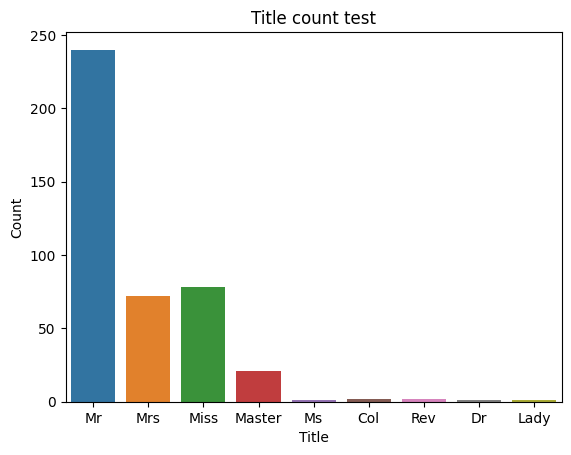

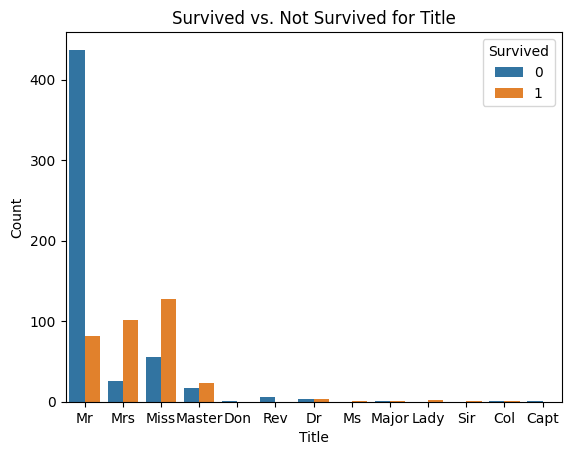

     Title  Survived
0     Capt  0.000000
1      Col  0.500000
2      Don  0.000000
3       Dr  0.428571
4     Lady  1.000000
5    Major  0.500000
6   Master  0.575000
7     Miss  0.699454
8       Mr  0.156371
9      Mrs  0.795276
10      Ms  1.000000
11     Rev  0.000000
12     Sir  1.000000


In [16]:
sns.countplot(x='Title', data=test_df)

# You can customize the plot as needed
plt.title('Title count test')
plt.xlabel('Title')
plt.ylabel('Count')
plt.show()

sns.countplot(x='Title', hue='Survived', data=train_df)

# You can customize the plot as needed
plt.title('Survived vs. Not Survived for Title')
plt.xlabel('Title')
plt.ylabel('Count')
plt.show()


title_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
title_survival_rate = train_df.groupby('Title')['Survived'].mean().reset_index()
print(title_survival_rate)


group0 = ['Capt', 'Mr', 'Rev']
group1 = ['Col', 'Dr', 'Major', 'Master']
group2 = ['Miss', 'Mrs', 'Ms']
group3 = ['Sir', 'Lady']


def set_prestige_by_title(df):
    df.loc[(df['Title'].isin(group0), 'Prestige')] = 'G0'
    df.loc[(df['Title'].isin(group1), 'Prestige')] = 'G1'
    df.loc[(df['Title'].isin(group2), 'Prestige')] = 'G2'
    df.loc[(df['Title'].isin(group3), 'Prestige')] = 'G3'
    

set_prestige_by_title(train_df)
set_prestige_by_title(test_df)


Now let's 1-hot encode Sex, Embarked, Cabin_class which are all categories

In [17]:
from sklearn.preprocessing import LabelEncoder

train_df_encoded = pd.get_dummies(train_df, columns=['Sex', 'Embarked', 'Cabin_class', 'Prestige'])
test_df_encoded = pd.get_dummies(test_df, columns=['Sex', 'Embarked', 'Cabin_class', 'Prestige'])
#train_df_encoded = pd.get_dummies(train_df, columns=['Sex', 'Embarked'])
#test_df_encoded = pd.get_dummies(test_df, columns=['Sex', 'Embarked'])

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

#train_df_encoded.loc[train_df_encoded['Cabin_class'] == 0, 'Cabin_class'] = "X"
#test_df_encoded.loc[test_df_encoded['Cabin_class'] == 0, 'Cabin_class'] = "X"

train_df_encoded.loc[train_df_encoded['Ticket_class'] == 0, 'Ticket_class'] = "NaN"
test_df_encoded.loc[test_df_encoded['Ticket_class'] == 0, 'Ticket_class'] = "NaN"

# Fit and transform the data
train_df_encoded['Title'] = label_encoder.fit_transform(train_df_encoded['Title'])
test_df_encoded['Title'] = label_encoder.fit_transform(test_df_encoded['Title'])

#train_df_encoded['Cabin_class'] = label_encoder.fit_transform(train_df_encoded['Cabin_class'])
#test_df_encoded['Cabin_class'] = label_encoder.fit_transform(test_df_encoded['Cabin_class'])

train_df_encoded['Ticket_class'] = label_encoder.fit_transform(train_df_encoded['Ticket_class'])
test_df_encoded['Ticket_class'] = label_encoder.fit_transform(test_df_encoded['Ticket_class'])


train_df_encoded.drop(['PassengerId'], axis=1, inplace=True)
test_df_encoded.drop(['PassengerId'], axis=1, inplace=True)


In [18]:
# In the correlation matrix we get that age is highly correlated with Pclass, 
# so let's compute median age by Pclass and then set the values for the missing
# entries. Do not forgot we have 0 for nans. 

# Assuming train_df and test_df are your training and test DataFrames
#combined_df = pd.concat([train_df, test_df], axis=0)

# Exclude rows with Age=0 for median calculation
#filtered_df = combined_df[combined_df['Age'] > 0]
filtered_df = train_df[train_df['Age'] > 0]

# Compute median age per Pclass
median_age_by_pclass = filtered_df.groupby('Pclass')['Age'].median().reset_index()

# Display the result
print(median_age_by_pclass)

# Merge the median values back into the original DataFrames based on 'Pclass'
train_df_encoded = train_df_encoded.merge(median_age_by_pclass, on='Pclass', how='left', suffixes=('', '_median'))
test_df_encoded = test_df_encoded.merge(median_age_by_pclass, on='Pclass', how='left', suffixes=('', '_median'))

# Replace 0 entries in 'Age' with the corresponding median values
train_df_encoded['Age'] = train_df_encoded.apply(lambda row: row['Age_median'] if row['Age'] == 0 else row['Age'], axis=1)
test_df_encoded['Age'] = test_df_encoded.apply(lambda row: row['Age_median'] if row['Age'] == 0 else row['Age'], axis=1)

# Drop the auxiliary columns used for median calculation
train_df_encoded.drop(columns=['Age_median'], inplace=True)
test_df_encoded.drop(columns=['Age_median'], inplace=True)

# Verify the changes
#print(train_df.head(1))
#print(test_df.head(1))
print(train_df_encoded['Age'].unique())
print(test_df_encoded['Age'].unique())

   Pclass   Age
0       1  37.0
1       2  29.0
2       3  24.0
[22.   38.   26.   35.   24.   54.    2.   27.   14.    4.   58.   20.
 39.   55.   29.   31.   34.   15.   28.    8.   19.   40.   37.   66.
 42.   21.   18.    3.    7.   49.   65.   28.5   5.   11.   45.   17.
 32.   16.   25.    0.83 30.   33.   23.   46.   59.   71.   47.   14.5
 70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.   56.
 50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.   60.
 10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.    0.67
 30.5   0.42 34.5  74.  ]
[34.5  47.   62.   27.   22.   14.   30.   26.   18.   21.   24.   46.
 23.   63.   35.   45.   55.    9.   37.   48.   50.   22.5  41.   33.
 18.5  25.   39.   60.   36.   20.   28.   29.   10.   17.   32.   13.
 31.   28.5  32.5   6.   67.   49.    2.   76.   43.   16.    1.   12.
 42.   53.   26.5  40.   61.   60.5   7.   15.   54.   64.   34.   11.5
  8.    0.33 38.   57.   40.5   0.92 19.   36.5   0.75

In [19]:
# Compute median age per Pclass
#df['how_many_x'] = df.groupby('x')['x'].transform('count')
train_df_encoded['Group_size'] = train_df_encoded.groupby('Ticket_num')['Ticket_num'].transform('count')
test_df_encoded['Group_size'] = test_df_encoded.groupby('Ticket_num')['Ticket_num'].transform('count')

train_df_encoded.loc[train_df_encoded['Group_size'] == 665, 'Group_size'] = 0
test_df_encoded.loc[test_df_encoded['Group_size'] == 665, 'Group_size'] = 0

#print(train_df_encoded.loc[train_df_encoded['Group_size'] > 1])

Next thing to do is to attach a family size to each passenger.

In [20]:
# summing up all sbsp (siblings, spouse) and parch (parents and children)
# to get a family size per passenger
train_df_encoded['Family_size'] = train_df_encoded['SibSp'] + train_df_encoded['Parch'] + 1
test_df_encoded['Family_size'] = test_df_encoded['SibSp'] + test_df_encoded['Parch'] + 1

# Print the DataFrame to see the changes
print(train_df_encoded.head(1))
print(train_df_encoded['Family_size'].unique())
print(test_df_encoded['Family_size'].unique())

   Survived  Pclass   Age  SibSp  Parch  Predicted_age  Ticket_num  \
0         0       3  22.0      1      0          False       21171   

   Ticket_class  Fare_group  Title  ...  Embarked_S  Cabin_class_H  \
0             0         1.0      8  ...        True          False   

   Cabin_class_L  Cabin_class_M  Prestige_G0  Prestige_G1  Prestige_G2  \
0           True          False         True        False        False   

   Prestige_G3  Group_size  Family_size  
0        False           1            2  

[1 rows x 24 columns]
[ 2  1  5  3  7  6  4  8 11]
[ 1  2  3  5  4  6  8  7 11]


In [21]:
#sns.countplot(x='Family_size', data=test_df_encoded)

#plt.title('Family_size count test')
#plt.xlabel('Family_size')
#plt.ylabel('Count')
#plt.show()

#sns.countplot(x='Family_size', hue='Survived', data=train_df_encoded)

#plt.title('Survived vs. Not Survived for Family_size')
#plt.xlabel('Family_size')
#plt.ylabel('Count')
#plt.show()


# Define age bins
#family_bins = [0, 2, 4, 20]  

# Create a new column with age groups
#train_df_encoded['Family_bin'] = pd.cut(train_df_encoded['Family_size'], bins=family_bins)

def set_family_bin(df):
    df.loc[(df['Family_size'] > 0) & \
                         (df['Family_size']<=2), 'Family_bin'] = 1
    df.loc[(df['Family_size'] > 2) & \
                         (df['Family_size']<=4), 'Family_bin'] = 2
    df.loc[(df['Family_size'] > 4) & \
                         (df['Family_size']<=20), 'Family_bin'] = 3
    
set_family_bin(train_df_encoded)
set_family_bin(test_df_encoded)

# Calculate the survival rate within each age group
family_survival_rate = train_df_encoded.groupby('Family_bin')['Survived'].mean().reset_index()
print(family_survival_rate)

#Since we engineered the family size, we no longer need it:
train_df_encoded.drop(['Family_size'], axis=1, inplace=True)
test_df_encoded.drop(['Family_size'], axis=1, inplace=True)


   Family_bin  Survived
0         1.0  0.361032
1         2.0  0.610687
2         3.0  0.161290


Let's examine the train and test data more carefully, to see what correlations we have, and get ideas for featuers engineering.

In [22]:

# Define age bins
age_bins = [0, 15, 65, 90]  # Adjust the bins according to your preference

# Create a new column with age groups
#train_df_encoded['Age_group'] = pd.cut(train_df_encoded['Age'], bins=age_bins)

# Calculate the survival rate within each age group
#age_survival_rate = train_df_encoded.groupby('Age_group')['Survived'].mean().reset_index()

#print(age_survival_rate)

train_df_encoded.head(2)

def set_age_group(df):
    df.loc[(df['Age'] > 0) & (df['Age']<=15), 'Age_group'] = 1
    df.loc[(df['Age'] > 15) & (df['Age']<=65), 'Age_group'] = 2
    df.loc[(df['Age'] > 65), 'Age_group'] = 3


set_age_group(train_df_encoded)
set_age_group(test_df_encoded)

#Since we engineered the Age to groups, we no longer need it:
train_df_encoded.drop(['Age'], axis=1, inplace=True)
test_df_encoded.drop(['Age'], axis=1, inplace=True)

test_df_encoded.head(2)

,Pclass,SibSp,Parch,Predicted_age,Ticket_num,Ticket_class,Fare_group,Title,Sex_female,Sex_male,...,Cabin_class_H,Cabin_class_L,Cabin_class_M,Prestige_G0,Prestige_G1,Prestige_G2,Prestige_G3,Group_size,Family_bin,Age_group
0,3,0,0,True,0.0,6,1.0,5,False,True,...,False,True,False,True,False,False,False,296,1.0,2.0
1,3,1,0,False,0.0,6,1.0,6,True,False,...,False,True,False,False,False,True,False,296,1.0,2.0


In [23]:
# Dropping features we no longer need due to above feature engineering:
train_df_encoded.drop(['Sex_female'], axis=1, inplace=True)
test_df_encoded.drop(['Sex_female'], axis=1, inplace=True)

train_df_encoded.drop(['Sex_male'], axis=1, inplace=True)
test_df_encoded.drop(['Sex_male'], axis=1, inplace=True)


train_df_encoded.drop(['Title'], axis=1, inplace=True)
test_df_encoded.drop(['Title'], axis=1, inplace=True)

#train_df_encoded.drop(['Cabin_class_0'], axis=1, inplace=True)
#test_df_encoded.drop(['Cabin_class_0'], axis=1, inplace=True)



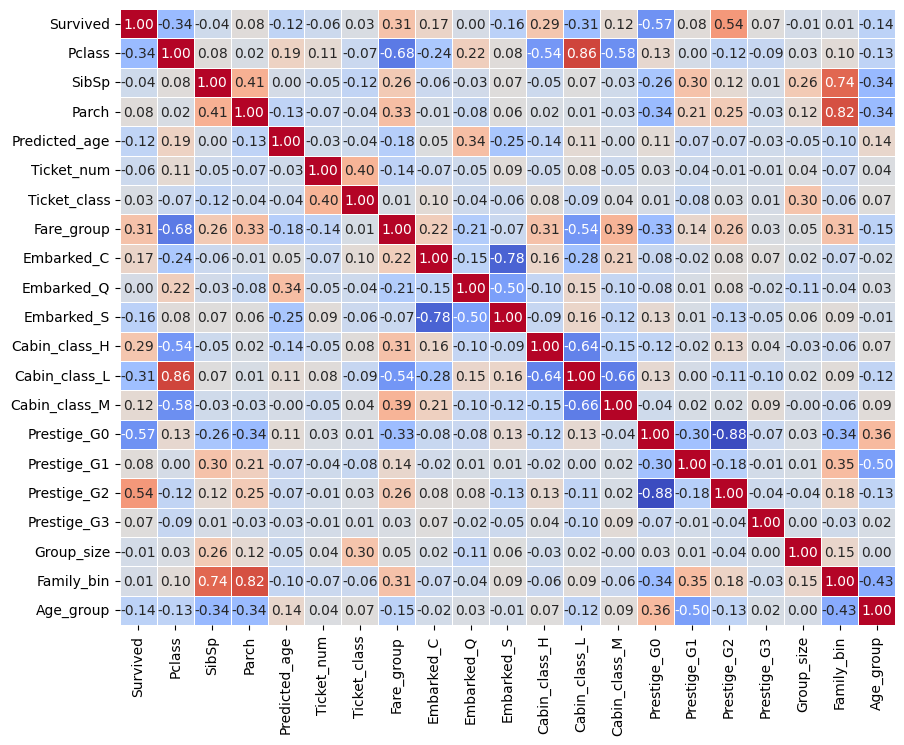

In [24]:
# we saw that one of the most important features for xgb is age. But we have tons of missing ages.
# How to set missing ages? basically Xgboost should be robust to that, and 
# predict by itself, but I'm curious to see if setting ages according to medians
# grouped by the highly correlated feature of age will help. 
# so let's look for feature to feature correlation. 
train_correlation_matrix = train_df_encoded.corr()
test_correlation_matrix = test_df_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with custom formatting for annot
sns.heatmap(train_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)

# Remove axis labels for a cleaner look
plt.xlabel('')
plt.ylabel('')

# Display the plot
plt.show()

Split to depndant and independant 

In [25]:
X = train_df_encoded.drop(['Survived'], axis=1).copy()
#print(X.head())
y = train_df_encoded['Survived'].copy()
#y.head()

Split the data to train and validation:

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [27]:
# verify we stratified by y properly:
print(sum(y_train)/len(y_train))
print(sum(y_val)/len(y_val))

print("length of train:", len(X_train))
print("length of train:", len(X_val))



0.38342696629213485
0.3854748603351955
length of train: 712
length of train: 179


# Training a model 

Yayy!! we are done with pre-processing, now we can build the model!


Let's build an XGBoost model:

In [28]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

scale_pos_weight = len(y_val)/sum(y_val)
print("calculated scale_pos_weight:", scale_pos_weight)

titanic_model = xgb.XGBClassifier(objective="binary:logistic",  
                                seed=42,
                               verbosity=0, 
                               n_estimators=100, 
                               eval_metric='error',
                               max_depth=4,
                                subsample=0.99,
                                eta=0.15,
                                gamma=0.25,
                                scale_pos_weight=1.2,
                                reg_lambda=40, 
                                early_stopping_rounds=9, 
                               min_child_weight=9, 
                               colsample_bytree=0.4)

evals_result = {}

titanic_model.fit(X_train, 
               y_train, 
               verbose=True,
                eval_set=[(X_train, y_train), (X_val, y_val)])


evals_result = titanic_model.evals_result()
#print(evals_result)

# Make predictions on the validation set
y_pred = titanic_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Total Accuracy: {accuracy * 100:.2f}%')

calculated scale_pos_weight: 2.5942028985507246
[0]	validation_0-error:0.38343	validation_1-error:0.38547
[1]	validation_0-error:0.38343	validation_1-error:0.38547
[2]	validation_0-error:0.21067	validation_1-error:0.22346
[3]	validation_0-error:0.19101	validation_1-error:0.18994
[4]	validation_0-error:0.18258	validation_1-error:0.19553
[5]	validation_0-error:0.17416	validation_1-error:0.18994
[6]	validation_0-error:0.17275	validation_1-error:0.18994
[7]	validation_0-error:0.17416	validation_1-error:0.18994
[8]	validation_0-error:0.17135	validation_1-error:0.18994
[9]	validation_0-error:0.16433	validation_1-error:0.18994
[10]	validation_0-error:0.16854	validation_1-error:0.17318
[11]	validation_0-error:0.16854	validation_1-error:0.17318
[12]	validation_0-error:0.16713	validation_1-error:0.17877
[13]	validation_0-error:0.16854	validation_1-error:0.17318
[14]	validation_0-error:0.16713	validation_1-error:0.16760
[15]	validation_0-error:0.16573	validation_1-error:0.17318
[16]	validation_0-

Grid search for hyperparams tuning:

In [29]:

from sklearn.model_selection import GridSearchCV

# scale_pos_weight = 62/38 # ~1.63 
grid_model = xgb.XGBClassifier(objective="binary:logistic",  
                                seed=42,
                               verbosity=0,
                               #n_estimators=300, 
                              eval_metric='error')

# Define the parameter grid for GridSearchCV
param_grid = {
    'eta': [0.15],
    'max_depth': [4],
    'scale_pos_weight': [1.2],
    'gamma': [0.25],
    'reg_lambda': [30],  # Default is 0.0 (L2 regularization)
    'subsample': [0.99],
    'min_child_weight': [9],
    'colsample_bytree': [0.4], 
    'early_stopping_rounds': [9], 
    'n_estimators': [100]
}

# Create GridSearchCV object
grid_search = GridSearchCV(grid_model, 
                           param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           verbose=0, 
                           n_jobs=-1)

# Fit the model
grid_search.fit(X_train, 
                y_train, 
                verbose=0,
                eval_set=[(X_val, y_val)])

# Print the best parameters and the corresponding score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)




Best Parameters:  {'colsample_bytree': 0.4, 'early_stopping_rounds': 9, 'eta': 0.15, 'gamma': 0.25, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100, 'reg_lambda': 30, 'scale_pos_weight': 1.2, 'subsample': 0.99}
Best Score:  0.8216290751502019


In [30]:
# Create a new XGBoost model with the best parameters

best_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric='error',
    seed=42,
    verbosity=0,
    #n_estimators=100,  # You may adjust this based on the best result
    **grid_search.best_params_  # Set the best parameters obtained from the grid search
)

print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=9,
              enable_categorical=False, eta=0.15, eval_metric='error',
              feature_types=None, gamma=0.25, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=9, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)


Do some plotting:

[0]	validation_0-error:0.38343	validation_1-error:0.38547
[1]	validation_0-error:0.38343	validation_1-error:0.38547
[2]	validation_0-error:0.21067	validation_1-error:0.22346
[3]	validation_0-error:0.19101	validation_1-error:0.18994
[4]	validation_0-error:0.18258	validation_1-error:0.19553
[5]	validation_0-error:0.17416	validation_1-error:0.18994
[6]	validation_0-error:0.17275	validation_1-error:0.18994
[7]	validation_0-error:0.17416	validation_1-error:0.18994
[8]	validation_0-error:0.17135	validation_1-error:0.18994
[9]	validation_0-error:0.16433	validation_1-error:0.18994
[10]	validation_0-error:0.16854	validation_1-error:0.17318
[11]	validation_0-error:0.16854	validation_1-error:0.17318
[12]	validation_0-error:0.16713	validation_1-error:0.17877
[13]	validation_0-error:0.16854	validation_1-error:0.17318
[14]	validation_0-error:0.16713	validation_1-error:0.16760
[15]	validation_0-error:0.16573	validation_1-error:0.17318
[16]	validation_0-error:0.16713	validation_1-error:0.17318
[17]	va

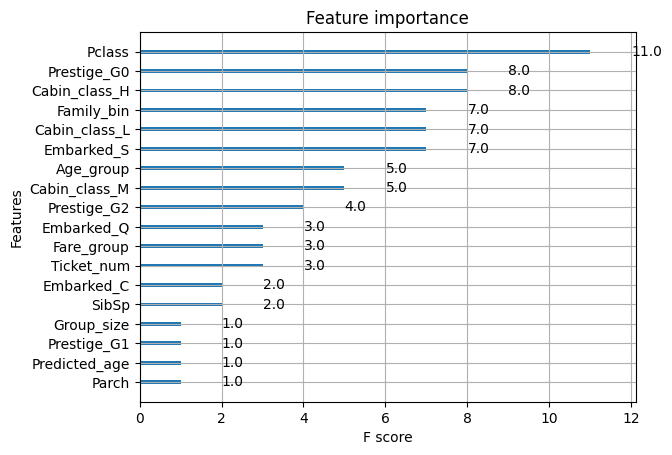

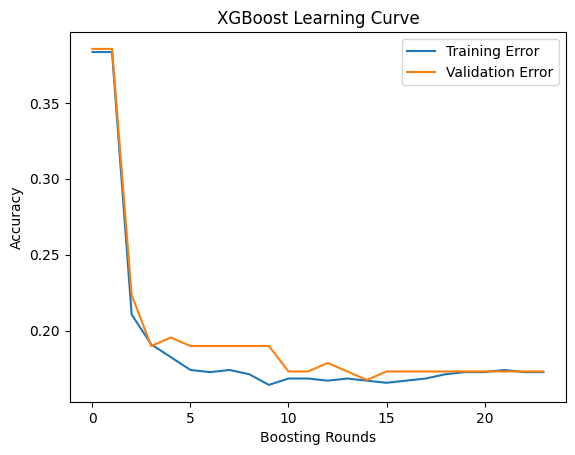

In [31]:
import matplotlib.pyplot as plt

best_model = titanic_model

best_model.fit(X_train, 
               y_train, 
               verbose=True,
                eval_set=[(X_train, y_train), (X_val, y_val)])


evals_result = best_model.evals_result()


############################
# Feature Importance Plot: #
############################
xgb.plot_importance(best_model, importance_type='weight')
plt.show()

##############
# Tree Plot: #
##############
#xgb.plot_tree(titanic_xgb, num_trees=0)
#plt.show()

###################
# Learning Curve: #
###################
# Example assuming 'validation_0' is used for training and 'validation_1' for validation
train_key = list(evals_result.keys())[0]
val_key = list(evals_result.keys())[1]

# Extract training and validation errors
train_error = np.array(evals_result[train_key]['error'])
val_error = np.array(evals_result[val_key]['error'])

# Plot learning curves
plt.plot(train_error, label='Training Error')
plt.plot(val_error, label='Validation Error')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.show()

Now let's run inference on test data and prepare csv for submission:

In [32]:

best_model.fit(X_train, 
               y_train, 
               verbose=True,
                eval_set=[(X_train, y_train), (X_val, y_val)])

val_predictions = best_model.predict(X_val)
# Calculate accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Total Val Accuracy: {val_accuracy * 100:.2f}%')

# Make predictions on the test set
test_predictions = best_model.predict(test_df_encoded)

# verify we stratified by y properly:
print("rate of survivors in test:", sum(test_predictions)/len(test_predictions))


#output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': test_predictions})
#output.to_csv('submission.csv', index=False)
#print("Your submission was successfully saved!")

[0]	validation_0-error:0.38343	validation_1-error:0.38547
[1]	validation_0-error:0.38343	validation_1-error:0.38547
[2]	validation_0-error:0.21067	validation_1-error:0.22346
[3]	validation_0-error:0.19101	validation_1-error:0.18994
[4]	validation_0-error:0.18258	validation_1-error:0.19553
[5]	validation_0-error:0.17416	validation_1-error:0.18994
[6]	validation_0-error:0.17275	validation_1-error:0.18994
[7]	validation_0-error:0.17416	validation_1-error:0.18994
[8]	validation_0-error:0.17135	validation_1-error:0.18994
[9]	validation_0-error:0.16433	validation_1-error:0.18994
[10]	validation_0-error:0.16854	validation_1-error:0.17318
[11]	validation_0-error:0.16854	validation_1-error:0.17318
[12]	validation_0-error:0.16713	validation_1-error:0.17877
[13]	validation_0-error:0.16854	validation_1-error:0.17318
[14]	validation_0-error:0.16713	validation_1-error:0.16760
[15]	validation_0-error:0.16573	validation_1-error:0.17318
[16]	validation_0-error:0.16713	validation_1-error:0.17318
[17]	va

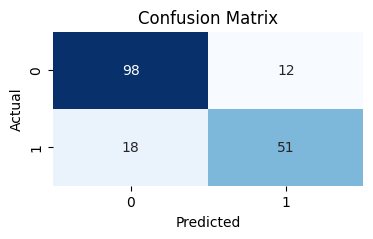

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Compute confusion matrix
cm = confusion_matrix(y_val, val_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
#display_missing(X_train)
#display_missing(X_val)
#display_missing(test_df_encoded)
#print(test_df_encoded['Fare_group'])

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
rf_model.fit(X_train, y_train)
rf_pred_val = rf_model.predict(X_val)
rf_pred_test = rf_model.predict(test_df_encoded)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, rf_pred_val)
print(f'Total Val Accuracy: {val_accuracy * 100:.2f}%')

# Survivors rate in test predictions
print("rate of survivors in test:", sum(rf_pred_test)/len(rf_pred_test))

print(len(rf_pred_test))
print(len(test_predictions))

Total Val Accuracy: 82.68%
rate of survivors in test: 0.3588516746411483
418
418


Total Val Accuracy: 82.68%
rate of survivors in test: 0.4090909090909091


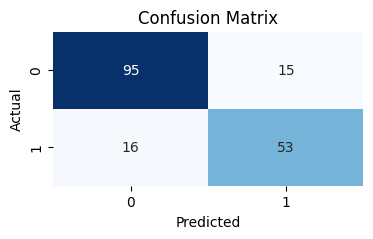

In [36]:
# Let's see the ensemble of Xgboost and random forest:

final_pred_test = rf_pred_test | test_predictions
final_pred_val = rf_pred_val | val_predictions
# Calculate accuracy
val_accuracy = accuracy_score(y_val, final_pred_val)
print(f'Total Val Accuracy: {val_accuracy * 100:.2f}%')

# Survivors rate in test predictions
print("rate of survivors in test:", sum(final_pred_test)/len(final_pred_test))


# Compute confusion matrix
cm = confusion_matrix(y_val, final_pred_val)

# Plot confusion matrix using seaborn
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Implement TabNet and then ensemble it with XGboost.
First, install

In [37]:
!pip install pytorch-tabnet

  Obtaining dependency information for pytorch-tabnet from https://files.pythonhosted.org/packages/0f/92/ed98b89b7cf5661656daa4cc88e578f712eb5eae41b8f46a56c1ece3a895/pytorch_tabnet-4.1.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.0 MB/s eta 0:00:00


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
import copy

In [39]:
def create_values_no_objects(df):
    # Identify boolean columns
    bool_columns = df.select_dtypes(include='bool').columns

    # Create a mask for boolean columns
    bool_mask = df.columns.isin(bool_columns)

    # Convert boolean values to numeric representation
    df_numeric = df.copy()
    df_numeric.loc[:, bool_mask] = df_numeric.loc[:, bool_mask].astype(int)

    # Extract the values from the DataFrame
    data = df_numeric.values

    
    return data

In [40]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

TabNetClassifier()


TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])

In [41]:
expected_rate = 0.38
def expected_survivors_rate(pred, threshold):
    rate = sum(pred)/len(pred)
    if (abs(rate-expected_rate) < threshold):
        return True
    return False

In [42]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Set seed for CPU operations
torch.manual_seed(42)

# create tensors out of the dfs:
X_train_np = create_values_no_objects(X_train)
y_train_np = y_train.values
X_val_np = create_values_no_objects(X_val)
y_val_np = y_val.values
X_test_np = create_values_no_objects(test_df_encoded)

best_train_acc = 0
best_val_acc = 0
best_diff = 100
best_n_steps = 0
best_n_a = 0
best_n_d = 0
best_n_shared = 0
best_lr = 0
best_gamma = 0

#learning_rates = 10**np.random.uniform(-3, 0, 10)
#learning_rates = [0.0498]
learning_rates = [0.0130]
n_a_arr = [9]
n_d_arr = [7]
n_shared_arr = [3]
n_steps_arr = [4]
#gamma_arr = np.random.uniform(0.9, 1, 3)
gamma_arr = [0.9477]

for _, n_step in enumerate(n_steps_arr):
    for _, lr in enumerate(learning_rates):
        for _, n_a in enumerate(n_a_arr):
            for _, n_d in enumerate(n_d_arr):
                for _, n_shared in enumerate(n_shared_arr):
                    for _, gamma in enumerate(gamma_arr):
                        # define the model
                        tabnet_model = TabNetClassifier(n_steps = n_step,
                                                        n_a = n_a, 
                                                        n_d = n_d, 
                                                        n_shared = n_shared,
                                                        seed = 42, 
                                                        verbose=False,
                                                        optimizer_fn=torch.optim.Adam,
                                                        optimizer_params={'lr': lr},
                                               scheduler_params={"step_size":10, 
                                                                 "gamma":gamma},
                                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                              )

                        # fit the model 
                        tabnet_model.fit(
                            X_train_np,y_train_np,
                            eval_set=[(X_train_np, y_train_np), (X_val_np, y_val_np)],
                            eval_name=['train', 'val'],
                            eval_metric=['accuracy'],
                            max_epochs=200, patience=60,
                            batch_size=512, virtual_batch_size=512,
                            num_workers=0,
                            weights=1,
                            drop_last=False
                        )

                        tabnet_pred_train = tabnet_model.predict(X_train_np)
                        tabnet_pred_val = tabnet_model.predict(X_val_np)
                        tabnet_pred_test = tabnet_model.predict(X_test_np)

                        train_acc = accuracy_score(y_train_np, tabnet_pred_train)
                        val_acc = accuracy_score(y_val_np, tabnet_pred_val)

                        if (best_diff > abs(train_acc - val_acc) 
                            and expected_survivors_rate(tabnet_pred_test, 0.04)
                            and train_acc > 0.815 
                            and val_acc > 0.815
                           ):
                            best_diff = train_acc - val_acc
                            best_train_acc = train_acc
                            best_val_acc = val_acc
                            best_n_steps = n_step
                            best_lr = lr
                            best_n_a = n_a
                            best_n_d = n_d
                            best_n_shared = n_shared
                            best_gamma = gamma

        
print("best diff:%.4f best train:%.4f best val:%.4f best_n_steps:%.4f, best_lr:%.4f"\
      %(best_diff, best_train_acc, best_val_acc, best_n_steps, best_lr))

print("best n_a:%.4f best n_d:%.4f best n_shared:%.4f best gamma:%.4f" %(best_n_a, best_n_d, best_n_shared, best_gamma))

#plt.plot(tabnet_model.history['loss'])
#plt.plot(tabnet_model.history['val']['loss'])
#plt.title('Loss curve')
#plt.show()

#plt.plot(tabnet_model.history['metric'])
#plt.plot(tabnet_model.history['val']['loss'])
#plt.title('Learning curve')
#plt.show()


Early stopping occurred at epoch 185 with best_epoch = 125 and best_val_accuracy = 0.8324
best diff:100.0000 best train:0.0000 best val:0.0000 best_n_steps:0.0000, best_lr:0.0000
best n_a:0.0000 best n_d:0.0000 best n_shared:0.0000 best gamma:0.0000


Run tabnet on test

In [43]:

tabnet_pred = tabnet_model.predict(X_test_np)
print("rate of survivors in test: %.2f" %(sum(tabnet_pred)/len(tabnet_pred) * 100) )




rate of survivors in test: 28.47


Blend the results of Xgb, random forest and tabnet alltogether

In [44]:
tabnet_pred_train = tabnet_model.predict_proba(X_train_np)
tabnet_pred_val = tabnet_model.predict_proba(X_val_np)
tabnet_pred_test = tabnet_model.predict_proba(X_test_np)

rf_pred_train = rf_model.predict_proba(X_train)
rf_pred_val = rf_model.predict_proba(X_val)
rf_pred_test = rf_model.predict_proba(test_df_encoded)

xgb_pred_train = titanic_model.predict_proba(X_train)
xgb_pred_val = titanic_model.predict_proba(X_val)
xgb_pred_test = titanic_model.predict_proba(test_df_encoded)


rf_weight = 0.35
xgb_weight = 0.65
tabnet_weight = 0

#print(rf_weight + xgb_weight + tabnet_weight)
#assert rf_weight + xgb_weight + tabnet_weight == 1.0, "Weights should sum to 1.0"

threshold = 0.5
blended_probabilities_train = \
(tabnet_weight*tabnet_pred_train + rf_weight*rf_pred_train + xgb_weight*xgb_pred_train)
blended_pred_train = (blended_probabilities_train[:, 1] > threshold).astype(int)

blended_probabilities_val = \
(tabnet_weight*tabnet_pred_val + rf_weight*rf_pred_val + xgb_weight*xgb_pred_val)
blended_pred_val = (blended_probabilities_val[:, 1] > threshold).astype(int)

blended_probabilities_test = \
(tabnet_weight*tabnet_pred_test + rf_weight*rf_pred_test + xgb_weight*xgb_pred_test)
blended_pred_test = (blended_probabilities_test[:, 1] > threshold).astype(int)


# Calculate accuracy on train
blended_acc_train = accuracy_score(y_train, blended_pred_train)
print(f'Total Blended Train Accuracy: {blended_acc_train * 100:.2f}%')
print("Blended survivors rate train: %.2f" %(sum(blended_pred_train)/len(blended_pred_train)*100))

# Calculate accuracy on validation
blended_acc_val = accuracy_score(y_val, blended_pred_val)
print(f'Total Blended Validation Accuracy: {blended_acc_val * 100:.2f}%')
print("Blended survivors rate val: %.2f" %(sum(blended_pred_val)/len(blended_pred_val)*100))


print("Blended survivors rate test: %.2f" %(sum(blended_pred_test)/len(blended_pred_test)*100))



Total Blended Train Accuracy: 84.27%
Blended survivors rate train: 36.10
Total Blended Validation Accuracy: 82.68%
Blended survivors rate val: 35.75
Blended survivors rate test: 39.47


Submit blended results:

In [45]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': blended_pred_test})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
